In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [159]:
from patsy import dmatrices
from statsmodels.formula.api import glm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [160]:
data = pd.read_csv('/Users/elizabethmurphy/Downloads/empirical_shedding_data.csv')
data = data.iloc[:, :-3]
data.head()
# solid_frac = Fraction of solids in the sample
# extraction_mass_mg = Mass used for RNA extraction
# N_conc (gc/mg-dw) = Viral nucleocapsid gene concentration
# N_det = Detection of N gene
# ORF1a_conc (gc/gm-dw) = ORF1a gene concentration
# ORF1a_det = Detection of ORF1a
# PMMoV_conc (gc/mg-dw) = Pepper mild mottle virus concentration
# PMMoV_det = Detection of PMMoV
# crAss_conc = crAssphage concentration
# crAss_quant = ?
# crAss_det = Detection of crAssphage

,ID,Day,solid_frac,extraction_mass_mg,N_conc (gc/mg-dw),N_det,ORF1a_conc (gc/gm-dw),ORF1a_det,PMMoV_conc (gc/mg-dw),PMMoV_det,crAss_conc,crAss_quant,crAss_det
0,4512,5,0.094133,11.5,1189.808219,True,3768.957713,True,NaN,False,1.054633e+07,True,True
1,4512,6,0.228228,17.5,649.722988,True,282.820595,True,175.807397,True,1.642356e+07,True,True
2,4512,7,0.187342,14.4,1203.595506,True,418.172285,True,941.273408,True,1.189325e+08,True,True
3,4514,13,0.135564,19.9,39.322095,False,39.322095,False,84.219268,False,2.540387e+02,False,True
4,4514,15,0.130321,16.7,59.181158,False,59.181158,True,771.928144,True,1.698420e+02,False,True


In [161]:
# Check for overdispersion
print(data["N_conc (gc/mg-dw)"].var()/data["N_conc (gc/mg-dw)"].mean()) # very high overdispersion
# Check for skew
data["N_conc (gc/mg-dw)"].skew() # data is right-skewed

971273.821965415


np.float64(9.10000045453068)

(0.0, 6000.0)

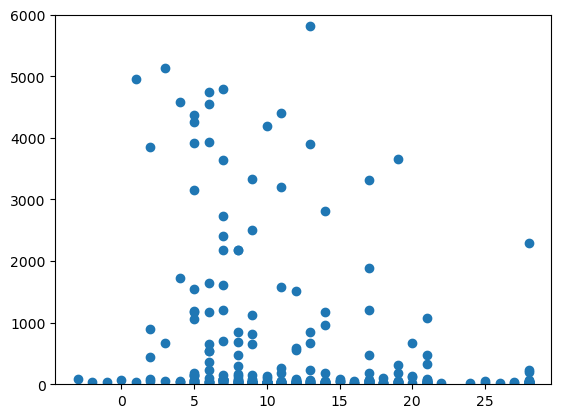

In [162]:
# plot shedding curve, not including outliers. 
fig,ax = plt.subplots()
ax.scatter(data['Day'],data['N_conc (gc/mg-dw)'])
ax.set_ylim([0,6000])

In [163]:
data['N_conc (gc/mg-dw)'] = data['N_conc (gc/mg-dw)'].fillna(0)
data['N_conc'] = data['N_conc (gc/mg-dw)']*data['N_det'] 
data['N_conc'] = pd.to_numeric(data['N_conc'], errors='coerce')
# If N_det is True: you get the original 'N_conc (gc/mg-dw)' value
# If N_det is False: the result becomes 0

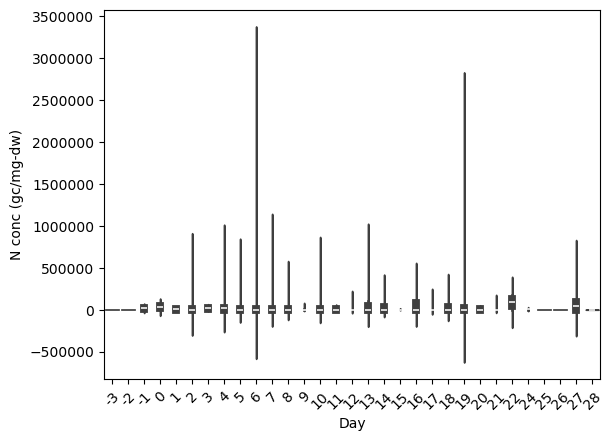

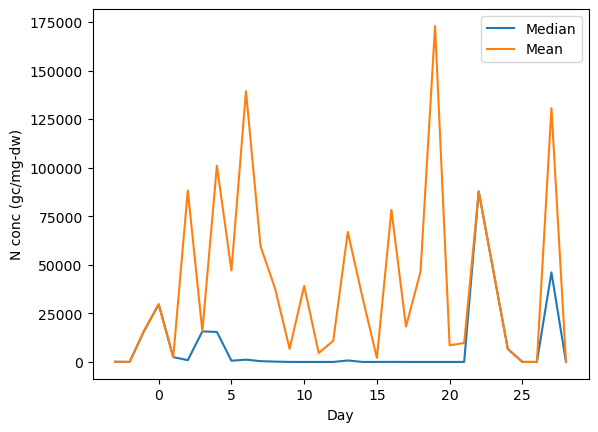

In [164]:
# Visualize Empirical Distributions Over Time
sns.violinplot(x='Day', y='N_conc', data=data)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('N conc (gc/mg-dw)')
plt.show()


# Median & Mean shedding per day
median_by_day = data.groupby('Day')['N_conc'].median()
mean_by_day = data.groupby('Day')['N_conc'].mean()

plt.plot(median_by_day.index, median_by_day.values, label='Median')
plt.plot(mean_by_day.index, mean_by_day.values, label='Mean')
plt.xlabel('Day')
plt.ylabel('N conc (gc/mg-dw)')
plt.legend()

# Why is there a peak around day 20 for the mean and median ?


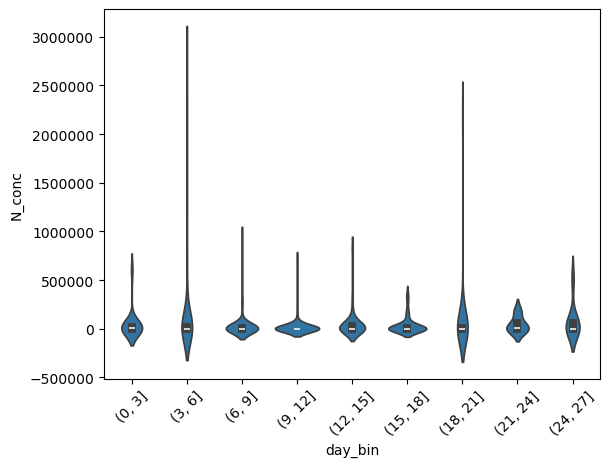

/var/folders/s2/nry612l527j2xxdsq0_70h6m0000gn/T/ipykernel_17856/1000627564.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_by_bin = data.groupby('day_bin')['N_conc'].median()
/var/folders/s2/nry612l527j2xxdsq0_70h6m0000gn/T/ipykernel_17856/1000627564.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = data.groupby('day_bin')['N_conc'].mean()


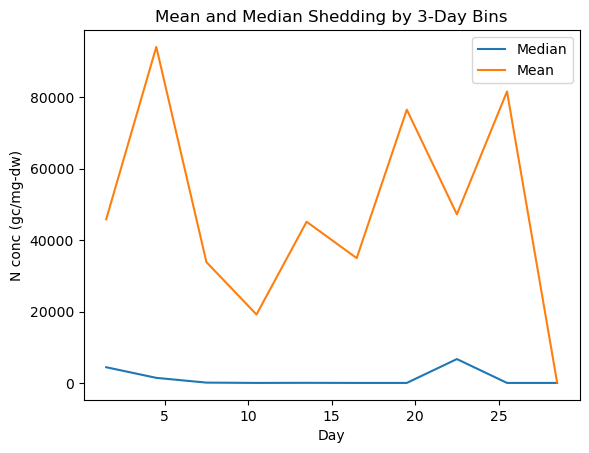

/var/folders/s2/nry612l527j2xxdsq0_70h6m0000gn/T/ipykernel_17856/1000627564.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_by_bin = data.groupby('day_bin')['N_conc'].median()
/var/folders/s2/nry612l527j2xxdsq0_70h6m0000gn/T/ipykernel_17856/1000627564.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = data.groupby('day_bin')['N_conc'].mean()


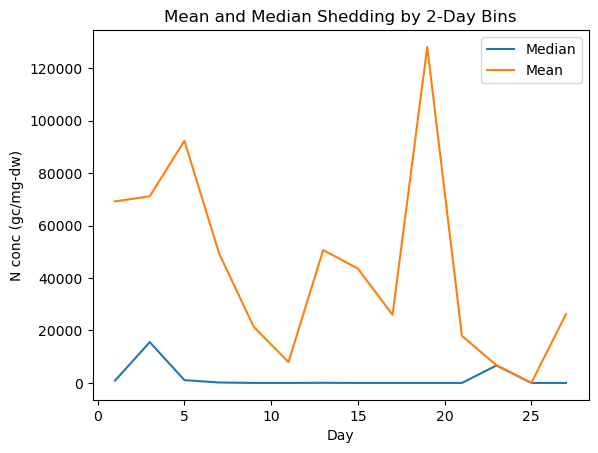

In [165]:
# Grouping days together
data['day_bin'] = pd.cut(data['Day'], bins=np.arange(0, 30, 3))  # 3 day bins
sns.violinplot(x='day_bin', y='N_conc', data=data)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()


# Median & Mean shedding (3 day bin)
data['day_bin'] = pd.cut(data['Day'], bins=np.arange(0, 33, 3))  # 3 day bin
median_by_bin = data.groupby('day_bin')['N_conc'].median()
mean_by_bin = data.groupby('day_bin')['N_conc'].mean()

bin_midpoints = median_by_bin.index.map(lambda x: x.left + (x.right - x.left)/2)

plt.plot(bin_midpoints, median_by_bin.values, label='Median')
plt.plot(bin_midpoints, mean_by_bin.values, label='Mean')
plt.xlabel('Day')
plt.ylabel('N conc (gc/mg-dw)')
plt.title('Mean and Median Shedding by 3-Day Bins')
plt.legend()
plt.show()


# Median & Mean shedding (2 day bin)
data['day_bin'] = pd.cut(data['Day'], bins=np.arange(0, 30, 2))  # 2 day bin
median_by_bin = data.groupby('day_bin')['N_conc'].median()
mean_by_bin = data.groupby('day_bin')['N_conc'].mean()

bin_midpoints = median_by_bin.index.map(lambda x: x.left + (x.right - x.left)/2)

plt.plot(bin_midpoints, median_by_bin.values, label='Median')
plt.plot(bin_midpoints, mean_by_bin.values, label='Mean')
plt.xlabel('Day')
plt.ylabel('N conc (gc/mg-dw)')
plt.title('Mean and Median Shedding by 2-Day Bins')
plt.legend()

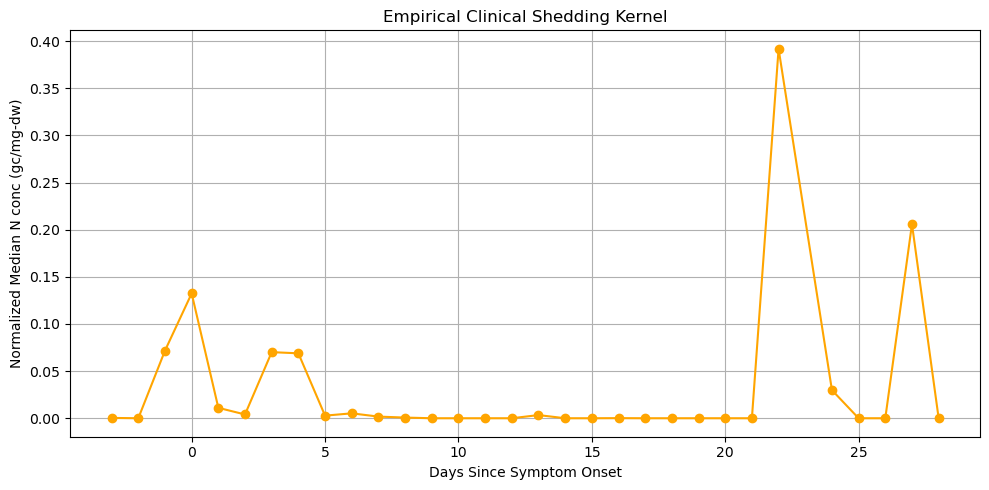

Text(0.5, 1.0, 'Comparison of Shedding Kernels')

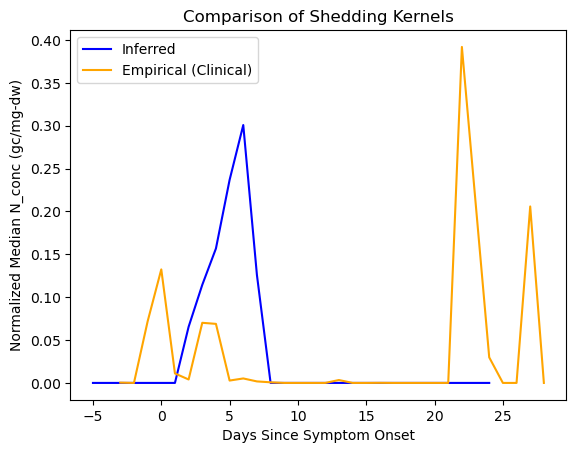

In [ ]:
# Construct a clinical shedding kernel from empirical data

# Normalize to sum to 1 (to use as a kernel)
# from above median_by_day = data.groupby('Day')['N_conc'].median()
clinical_kernel = median_by_day / median_by_day.sum()

plt.figure(figsize=(10, 5))
plt.plot(clinical_kernel.index, clinical_kernel.values, marker='o', color='orange')
plt.title('Empirical Clinical Shedding Kernel')
plt.xlabel('Days Since Symptom Onset')
plt.ylabel('Normalized Median N conc (gc/mg-dw)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalized
k_learned = x.value / np.sum(x.value)
days = np.arange(-F, len(k_learned)-F)

# Compare to empirical kernel
plt.plot(days, k_learned, label="Inferred", color='blue')
plt.plot(clinical_kernel.index, clinical_kernel.values / clinical_kernel.sum(), label="Empirical (Clinical)", color='orange')
plt.xlabel('Days Since Symptom Onset')
plt.ylabel('Normalized Median N_conc (gc/mg-dw)')
plt.legend()
plt.title("Comparison of Shedding Kernels")

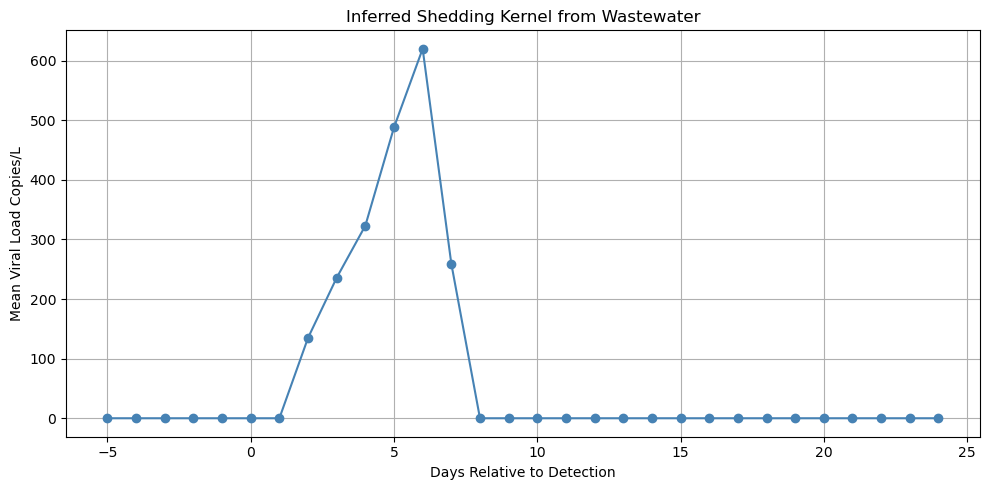

In [167]:
days = np.arange(-F, len(x.value) - F)

plt.figure(figsize=(10, 5))
plt.plot(days, x.value, marker='o', color='steelblue')
plt.title('Inferred Shedding Kernel from Wastewater')
plt.xlabel('Days Relative to Detection')
plt.ylabel('Mean Viral Load Copies/L')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/s2/nry612l527j2xxdsq0_70h6m0000gn/T/ipykernel_17856/1112181025.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cdf['Sample_Date'] = pd.to_datetime(cdf['Sample_Date'])


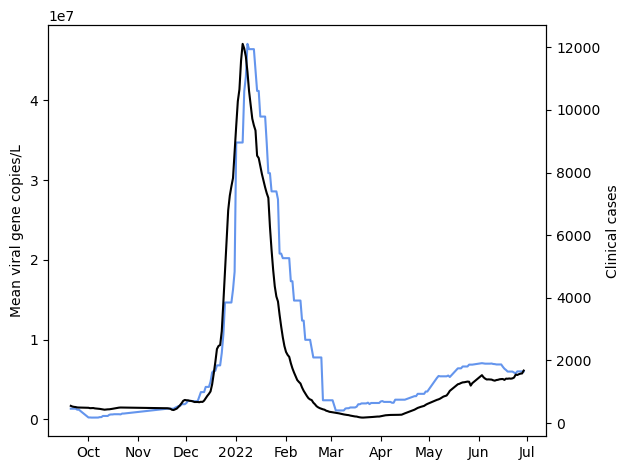

(CVXPY) Jun 30 12:24:35 PM: Your problem has 30 variables, 30 constraints, and 0 parameters.
(CVXPY) Jun 30 12:24:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 30 12:24:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 30 12:24:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 30 12:24:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jun 30 12:24:35 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Jun 30 12:24:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Jun 30 12:24:35 PM: Applying reduction Dcp2Cone
(CVXPY) Jun 30 12:24:35 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jun 30 12:24:35 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jun 30 12:24:35 PM: Applying reduction CLARABEL
(CVXPY) Jun 30 12:24:35 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 31
  constraints 

(CVXPY) Jun 30 12:24:35 PM: Problem status: optimal
(CVXPY) Jun 30 12:24:35 PM: Optimal value: 8.113e+03
(CVXPY) Jun 30 12:24:35 PM: Compilation took 4.741e-03 seconds
(CVXPY) Jun 30 12:24:35 PM: Solver (including time spent in interface) took 4.577e-03 seconds
(CVXPY) Jun 30 12:24:35 PM: Your problem has 30 variables, 0 constraints, and 0 parameters.
(CVXPY) Jun 30 12:24:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 30 12:24:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 30 12:24:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 30 12:24:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jun 30 12:24:35 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Jun 30 12:24:35 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Jun 30 

  0  +0.0000e+00  -0.0000e+00  0.00e+00  8.17e-01  1.01e-02  1.00e+00  2.60e+04   ------   
  1  +6.3576e+03  +6.3842e+03  4.19e-03  1.98e-01  1.93e-04  2.67e+01  3.00e+03  8.86e-01  
  2  +6.8042e+03  +7.0396e+03  3.46e-02  1.45e-01  1.33e-04  2.35e+02  2.68e+03  2.39e-01  
  3  +7.5963e+03  +7.7996e+03  2.68e-02  3.10e-02  2.59e-05  2.03e+02  1.59e+03  7.80e-01  
  4  +7.4796e+03  +7.9045e+03  5.68e-02  5.00e-02  4.18e-05  4.25e+02  1.55e+03  1.64e-01  
  5  +7.5917e+03  +7.6848e+03  1.23e-02  1.45e-02  1.21e-05  9.31e+01  5.13e+02  7.38e-01  
  6  +7.8421e+03  +7.8894e+03  6.04e-03  4.71e-03  3.87e-06  4.74e+01  1.16e+02  8.34e-01  
  7  +7.9723e+03  +7.9882e+03  2.00e-03  1.82e-03  1.49e-06  1.60e+01  4.35e+01  7.00e-01  
  8  +8.0359e+03  +8.0523e+03  2.05e-03  1.46e-03  1.19e-06  1.65e+01  2.38e+01  5.79e-01  
  9  +8.0958e+03  +8.0979e+03  2.60e-04  2.82e-04  2.28e-07  2.11e+00  5.04e+00  8.40e-01  
 10  +8.1110e+03  +8.1112e+03  2.99e-05  3.86e-05  3.13e-08  2.43e-01  7.02e-01 

(CVXPY) Jun 30 12:24:35 PM: Problem status: optimal
(CVXPY) Jun 30 12:24:35 PM: Optimal value: -1.400e+02
(CVXPY) Jun 30 12:24:35 PM: Compilation took 7.013e-03 seconds
(CVXPY) Jun 30 12:24:35 PM: Solver (including time spent in interface) took 1.118e-02 seconds


  0  +0.0000e+00  -4.2154e+02  4.22e+02  8.86e-01  1.26e+01  1.00e+00  1.00e+00   ------   
  1  +1.6563e+02  -3.6742e-01  1.66e+02  2.62e-01  3.99e+00  5.73e-01  2.94e-01  7.28e-01  
  2  +1.3699e+02  +4.6079e+01  1.97e+00  1.56e-01  2.09e+00  2.78e-01  1.72e-01  5.57e-01  
  3  +1.2841e+02  +8.2480e+01  5.57e-01  8.14e-02  9.02e-01  1.37e-01  8.88e-02  5.54e-01  
  4  +1.2812e+02  +9.8253e+01  3.04e-01  5.54e-02  4.25e-01  9.29e-02  5.55e-02  5.37e-01  
  5  +1.3389e+02  +1.1626e+02  1.52e-01  3.43e-02  1.47e-01  6.16e-02  2.90e-02  6.07e-01  
  6  +1.3748e+02  +1.2729e+02  8.00e-02  2.02e-02  6.18e-02  3.83e-02  1.52e-02  5.00e-01  
  7  +1.3963e+02  +1.3723e+02  1.75e-02  4.80e-03  1.19e-02  8.57e-03  3.35e-03  9.90e-01  
  8  +1.3994e+02  +1.3939e+02  3.92e-03  1.10e-03  2.52e-03  1.99e-03  7.44e-04  7.92e-01  
  9  +1.4001e+02  +1.4000e+02  7.71e-05  2.17e-05  4.89e-05  4.14e-05  1.46e-05  9.90e-01  
 10  +1.4002e+02  +1.4001e+02  1.65e-05  4.65e-06  1.05e-05  8.89e-06  3.13e-06 

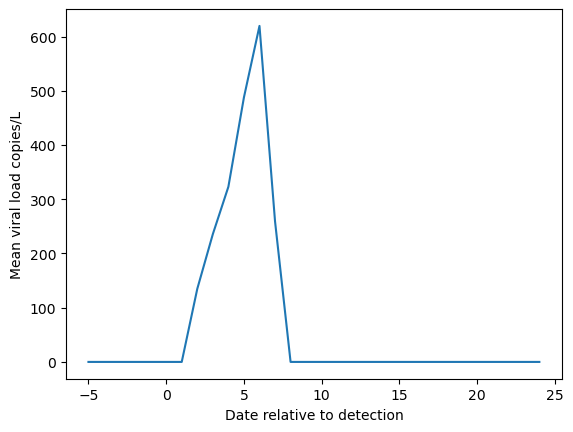

In [168]:
# Josh's infer_shedding_kernel.py code
import pandas as pd
import pickle
import json
import requests
from scipy import signal
from datetime import date,timedelta
import yaml
import copy
import numpy as np

import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

start = pd.to_datetime('2023-01-01')
# creates a list of 52 dates at weekly intervals starting from start (Jan 1, 2023)
eval_dates = [start + datetime.timedelta(days=7*j) for j in range(0,52)]

cases = pd.read_csv('/Users/elizabethmurphy/Downloads/covid19cases_test.csv',index_col=0)
cases = cases[cases['area'] =='San Diego']
# data between June 1, 2020 and July 1, 2022
cases = cases[(cases.index>='2020-06-01') & (cases.index<='2022-07-01')]
cases.index = pd.to_datetime(cases.index)

# smooths daily cases using a 7 day centered moving average
cases['cases'] = cases['cases'].rolling(window=7, center=True, min_periods=0).mean()
# computes positivity rate as the 7-day average of cases divided by 7-day average of total tests
cases['positivity'] = cases['cases'].rolling(window=7, center=True, min_periods=0).mean()/cases['total_tests'].rolling(window=7, center=True, min_periods=0).mean()

ww_dict = {'Point Loma':['/Users/elizabethmurphy/Downloads/PointLoma_sewage_seqs.csv','/Users/elizabethmurphy/Downloads/PointLoma_sewage_qPCR.csv']}
for site, files in zip(ww_dict.keys(),ww_dict.values()): # Iterate through the dictionary to process each site
    df = pd.read_csv(f'{files[0]}') # Load sequencing data (variant fractions)

    # Convert 'Date' column to datetime and set it as index. Also, clean column names
    df['Date'] = pd.to_datetime(df['Date'])
    df.columns = [dfc.split(' (')[0] for dfc in df.columns]
    df =df.set_index('Date')
    # Keep records between June 2020 and July 2022
    df = df[df.index>='2020-06-01']
    df = df[df.index<='2022-07-01']
    # Drop rows that are completely NaN and fill remaining NaNs with 0
    df = df.dropna(axis = 0, how = 'all')
    df = df.fillna(0)
    # Convert percentages to proportions
    df = df/100.

    # Drop the "Other" column and remove variant columns with total contribution < 1%
    df = df.drop(columns=['Other'])
    df = df[df.columns[df.sum(axis=0) > 0.01]]

    cdf = pd.read_csv(f'{files[1]}')
    cdf['Sample_Date'] = pd.to_datetime(cdf['Sample_Date'])
    cdf =cdf.set_index('Sample_Date') # set sample date as the index
    # Align cdf and df to only the shared dates
    sharedInds = np.sort(list(set(cdf.index) & set(df.index)))
    cdf = cdf.loc[sharedInds]
    df = df.loc[sharedInds]
    # Drop duplicated index entries
    df = df[~df.index.duplicated(keep='last')]
    # Scale variant fractions by total viral load — this gives absolute abundance per variant
    scaleddf = df.mul(cdf['Mean viral gene copies/L'],axis=0)

    # Resample cdf to daily frequency (fill missing days with NaN), then smooth via 7 day rolling mean
    cdf = cdf.resample('D').asfreq()
    cdf = cdf.rolling(window=7, center=True, min_periods=0).mean()

# Join smoothed wastewater and clinical case data into single DataFrame and drop rows with missing values
cdf = pd.concat([cdf,cases],axis=1)
cdf = cdf.dropna(how='any')

N = 30 # N: kernel length (30 days)
F = 5 # F: forward shift (5 days)
# first, let's learn the shedding kernel. 
# X: matrix where each row is a 30 day backward-looking viral load window, normalized by mean
X = np.array([cdf['Mean viral gene copies/L'].values[(j-F):(j+N-F)] for j in range(F,(cdf.shape[0]-N+F))])/cdf['Mean viral gene copies/L'].mean()
# add coeficient term
Y= cdf['cases'].values[F:(len(cdf['cases'])-N+F)] # Y: corresponding case counts, aligned with the design matrix

import cvxpy as cp

fig,ax = plt.subplots()
ax.plot(cdf.index,cdf['Mean viral gene copies/L'],color='cornflowerblue')
ax.set_ylabel('Mean viral gene copies/L')
ax2 = ax.twinx()
ax2.plot(cdf.index,cdf['cases'],color='black')
ax2.set_ylabel('Clinical cases')
locator = mdates.MonthLocator(bymonthday=1)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
fig.tight_layout()
plt.show()
# blue line represents the smoothed wastewater SARS-CoV-2 viral load
# black line represents the the smoothed number of clinical COVID-19 cases

# Defines a constrained least squares optimization to estimate kernel x
# least squares problem
x = cp.Variable(N)
cost = cp.norm(X @ x - Y,2)
constraints = [x >= 0]
prob = cp.Problem(cp.Minimize(cost),constraints)
prob.solve(verbose=True)#,solver=cp.CLARABEL)

Y2= cdf['positivity'].values[0:(len(cdf['positivity'])-N)]

# Uses a Poisson-like logistic model for positivity rate
# switch to logistic function
beta = cp.Variable(N,nonneg=True)#+1)
log_likelihood = cp.sum(
    cp.multiply(Y2, X @ beta) - cp.logistic(X @ beta)
)
# constraints = [beta >= 0.001, beta<=10]
prob2 = cp.Problem(cp.Maximize(log_likelihood))#,constraints)
prob2.solve(verbose=True)#,solver=cp.CLARABEL)

fig,ax = plt.subplots()
ax.plot(range(-F,len(x.value)-F),x.value) # just plotting the curve learned via the case counts for now. 
ax.set_xlabel('Date relative to detection')
ax.set_ylabel('Mean viral load copies/L')
plt.show()